In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import keras_tuner as kt
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('/kaggle/input/cleaned-solar-energy-dataset/Solar_energy_cleaned.csv')

In [20]:
start_date = pd.to_datetime('2022-06-07 00:00')

df['Time'] = pd.date_range(start=start_date, periods=len(df), freq='h')

In [21]:
df

,Time,SolarEnergy
0,2022-06-07 00:00:00,0.000000
1,2022-06-07 01:00:00,0.000000
2,2022-06-07 02:00:00,0.000000
3,2022-06-07 03:00:00,0.000000
4,2022-06-07 04:00:00,0.000000
...,...,...
5248,2023-01-11 16:00:00,0.582284
5249,2023-01-11 17:00:00,0.033335
5250,2023-01-11 18:00:00,0.000000
5251,2023-01-11 19:00:00,0.000000


In [22]:
#df.loc[df['SolarEnergy'] <= 0, 'SolarEnergy'] = 0

In [23]:
df[df.SolarEnergy < 0].shape[0]

0

In [24]:
df.head(24)

,Time,SolarEnergy
0,2022-06-07 00:00:00,0.000000
1,2022-06-07 01:00:00,0.000000
2,2022-06-07 02:00:00,0.000000
3,2022-06-07 03:00:00,0.000000
4,2022-06-07 04:00:00,0.000000
5,2022-06-07 05:00:00,0.099041
6,2022-06-07 06:00:00,0.765115
7,2022-06-07 07:00:00,1.733899
8,2022-06-07 08:00:00,2.829990
9,2022-06-07 09:00:00,3.828032


In [25]:
#df.to_csv('Solar_energy_cleaned.csv', index=False)

In [26]:
def create_dataset(serie, time_steps=1):
    Xs, ys = [], []
    for i in range(len(serie) - time_steps):
        Xs.append(serie.iloc[i:(i + time_steps)].values)
        ys.append(serie.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [96]:
scaler = MinMaxScaler(feature_range=(0,1))

In [97]:
time_steps = 15
X, y = create_dataset(df.SolarEnergy, time_steps)
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1,1))

In [98]:
names = [f"X{i}" for i in range(15)]
data = pd.DataFrame(X_scaled, columns=names)
data["Y"] = y_scaled
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,0.0,0.000000,0.000000,0.000000,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266
1,0.0,0.000000,0.000000,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503
2,0.0,0.000000,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503,0.263605
3,0.0,0.000000,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503,0.263605,0.095862
4,0.0,0.017778,0.137337,0.311232,0.507978,0.687124,0.815943,0.888539,0.925525,0.872289,0.789631,0.645266,0.452503,0.263605,0.095862,0.005332


In [99]:
X.shape

(5238, 15)

In [100]:
X_resh = X_scaled.reshape(len(X), time_steps,1)

In [101]:
X_temp, X_test, y_temp, y_test = train_test_split(X_resh, y_scaled,test_size = 0.15, random_state=42, shuffle=False)

In [102]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, shuffle=False
)

In [103]:
window_size = time_steps

In [35]:
val_loss = {
    'Simple RNN': 0,
    'LSTM': 0,
    'BILSTM': 0,
    'GRU': 0
}

In [36]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [37]:
#!rm -rf /kaggle/working/best_model_BiLSTM.h5

In [38]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

    
def model_builder_simpleRNN(hp):
    model = tf.keras.Sequential()

    # hyperparameters
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', ['relu', 'tanh'])

    model.add(tf.keras.layers.SimpleRNN(units=hp_units, activation=hp_activation, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')

    return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# run the search with GPU
with strategy.scope():
    tuner_simRNN = kt.Hyperband(
        model_builder_simpleRNN,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='simpleRNN'
    )


tuner_simRNN.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps_simRNN = tuner_simRNN.get_best_hyperparameters(num_trials=1)[0]
best_trial_simRNN = tuner_simRNN.oracle.get_best_trials(num_trials=1)[0]
val_loss = {}
val_loss['Simple RNN'] = best_trial_simRNN.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
The validation loss is: {val_loss['Simple RNN']:.6f}
Best number of units: {best_hps_simRNN.get('units')}
Best learning rate: {best_hps_simRNN.get('learning_rate')}
Best activation: {best_hps_simRNN.get('activation')}
""")


Trial 30 Complete [00h 00m 06s]
val_loss: 0.04958683252334595

Best val_loss So Far: 0.001386874821037054
Total elapsed time: 00h 02m 24s

The validation loss is: 0.001387
Best number of units: 64
Best learning rate: 0.01
Best activation: relu



In [39]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_lstm(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    model.add(tf.keras.layers.LSTM(units=hp_units, activation=hp_activation, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(1, activation='relu'))  # Output layer

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse'
    )

    return model


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


with strategy.scope():
    tuner_LSTM = kt.Hyperband(
        model_builder_lstm,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='lstm'
    )

# run the search with GPU
tuner_LSTM.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
    callbacks=[stop_early]
)

# Retrieve best hyperparameters and validation loss
best_hps_LSTM = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]
best_trial_LSTM = tuner_LSTM.oracle.get_best_trials(num_trials=1)[0]

val_loss['LSTM'] = best_trial_LSTM.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
LSTM Validation Loss: {val_loss['LSTM']:.6f}
Optimal Units: {best_hps_LSTM.get('units')}
Optimal Learning Rate: {best_hps_LSTM.get('learning_rate')}
Optimal Activation: {best_hps_LSTM.get('activation')}
""")


Trial 30 Complete [00h 00m 07s]
val_loss: 0.0022555729374289513

Best val_loss So Far: 0.001368564902804792
Total elapsed time: 00h 02m 46s

LSTM Validation Loss: 0.001369
Optimal Units: 64
Optimal Learning Rate: 0.01
Optimal Activation: relu



In [40]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras


# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_Bilstm(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh']) 

    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=hp_units, activation=hp_activation),
        input_shape=(window_size, 1)
    ))
    model.add(tf.keras.layers.Dense(1, activation='relu')) 

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse'
    )

    return model


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# run the search with GPU
with strategy.scope():

    tuner_Bidirectional = kt.Hyperband(
    model_builder_Bilstm,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='Bilstm'
    )
    
tuner_Bidirectional.search(
    X_train, y_train, epochs=50, validation_data=(X_val, y_val),
    callbacks=[stop_early]
)


best_hps_Bidirectional = tuner_Bidirectional.get_best_hyperparameters(num_trials=1)[0]
best_trial_Bidirectional = tuner_Bidirectional.oracle.get_best_trials(num_trials=1)[0]
val_loss['BILSTM'] = best_trial_Bidirectional.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
BiLSTM Validation Loss: {val_loss['BILSTM']:.6f}
Optimal Units: {best_hps_Bidirectional.get('units')}
Optimal Learning Rate: {best_hps_Bidirectional.get('learning_rate')}
Optimal Activation: {best_hps_Bidirectional.get('activation')}
""")


Trial 30 Complete [00h 00m 14s]
val_loss: 0.0015607953537255526

Best val_loss So Far: 0.0011193713871762156
Total elapsed time: 00h 03m 43s

BiLSTM Validation Loss: 0.001119
Optimal Units: 288
Optimal Learning Rate: 0.01
Optimal Activation: relu



In [41]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

# this is for the GPU
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


def model_builder_gru(hp):
    model = tf.keras.models.Sequential()

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    model.add(tf.keras.layers.Reshape((window_size, 1), input_shape=[window_size]))
    model.add(tf.keras.layers.GRU(units=hp_units, activation=hp_activation))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')
    return model

# run the search with GPU
with strategy.scope():
    tuner_GRU = kt.Hyperband(
        model_builder_gru,
        objective='val_loss',
        max_epochs=10,
        factor=3,
        directory='my_dir',
        project_name='gru'
    )


tuner_GRU.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps_GRU = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]
best_trial_GRU = tuner_GRU.oracle.get_best_trials(num_trials=1)[0]
val_loss['GRU'] = best_trial_GRU.metrics.get_best_value('val_loss')

print("="*100)
print(f"""
GRU Validation Loss: {val_loss['GRU']}
Optimal Units: {best_hps_GRU.get('units')}
Optimal Learning Rate: {best_hps_GRU.get('learning_rate')}
Optimal Activation: {best_hps_GRU.get('activation')}
""")


Trial 30 Complete [00h 00m 08s]
val_loss: 0.0016000240575522184

Best val_loss So Far: 0.0016000240575522184
Total elapsed time: 00h 03m 01s

GRU Validation Loss: 0.0016000240575522184
Optimal Units: 128
Optimal Learning Rate: 0.01
Optimal Activation: tanh



In [42]:
val_loss

{'Simple RNN': 0.001386874821037054,
 'LSTM': 0.001368564902804792,
 'BILSTM': 0.0011193713871762156,
 'GRU': 0.0016000240575522184}

In [43]:
best_model_rnn = tuner_simRNN.get_best_models(num_models=1)[0]
best_model_lstm = tuner_LSTM.get_best_models(num_models=1)[0]
best_model_bilstm = tuner_Bidirectional.get_best_models(num_models=1)[0]
best_model_gru = tuner_GRU.get_best_models(num_models=1)[0]

best_hp_rnn = tuner_simRNN.get_best_hyperparameters(num_trials=1)[0]
best_hp_lstm = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]
best_hp_bilstm = tuner_Bidirectional.get_best_hyperparameters(num_trials=1)[0]
best_hp_gru = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_hp_pairs = [
    (best_model_rnn, best_hp_rnn),
    (best_model_lstm, best_hp_lstm),
    (best_model_bilstm, best_hp_bilstm),
    (best_model_gru, best_hp_gru)
]

histories = []
best_models = []

for model, hp in model_hp_pairs:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get('learning_rate')),
        loss='mse'
    )
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    best_models.append(model)
    histories.append(history)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 11/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 12/100
115/115 ━━━━━━━━━━━━━━━━━━━

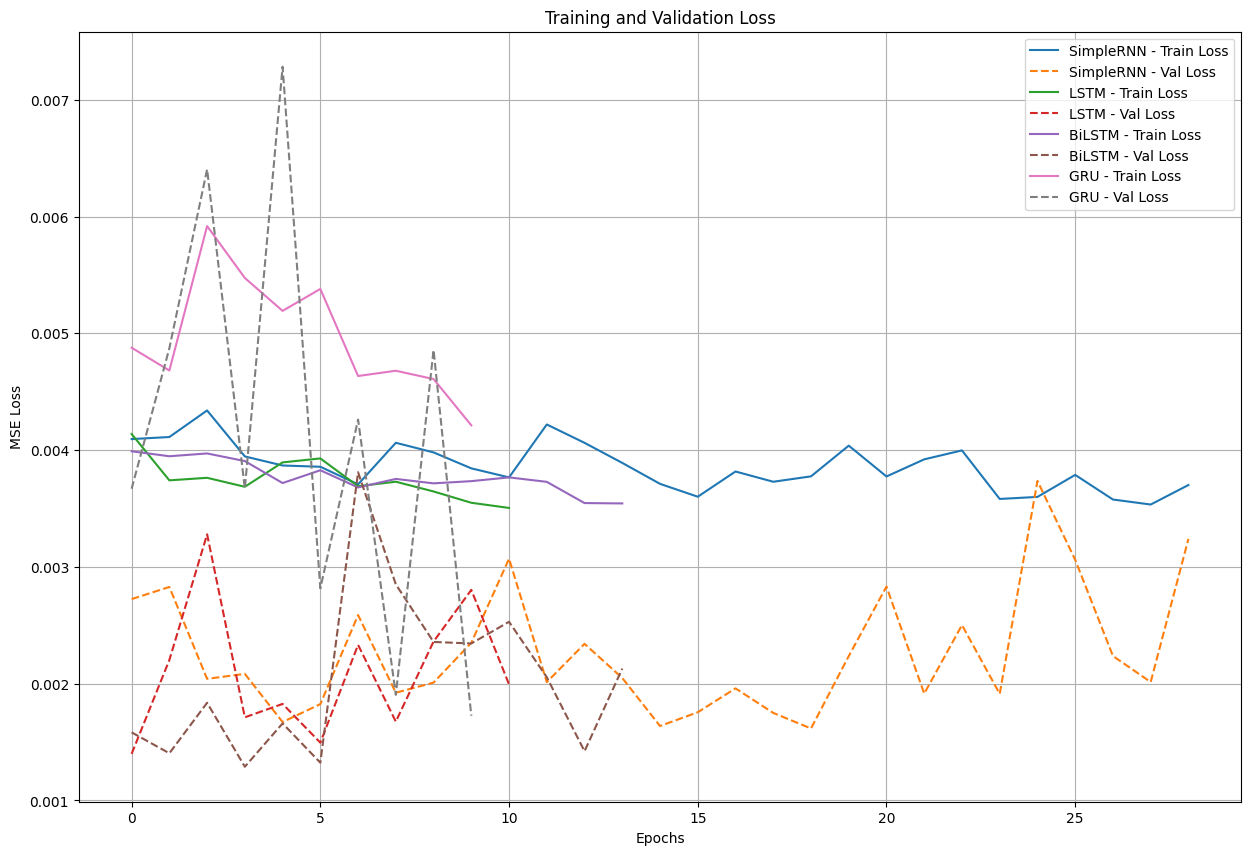

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1500x1000 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import mean_absolute_error

model_names = ['SimpleRNN', 'LSTM', 'BiLSTM', 'GRU']
r2_scores = {}
mse_scores = {}
mae_scores = {}

plt.figure(figsize=(15, 10))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'{model_names[i]} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_names[i]} - Val Loss', linestyle='--')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


for i, model in enumerate(best_models):
    y_preds = model.predict(X_test).flatten()
    
    mse = mean_squared_error(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)

    r2_scores[model_names[i]] = r2
    mse_scores[model_names[i]] = mse
    mae_scores[model_names[i]] = mae
plt.figure(figsize=(15, 10))

r2_scores = {}
mse_scores = {}
mae_scores = {}

for i, model in enumerate(best_models):
    y_preds = model.predict(X_test).flatten()

    r2_scores[model_names[i]] = r2_score(y_test, y_preds)
    mse_scores[model_names[i]] = mean_squared_error(y_test, y_preds)
    mae_scores[model_names[i]] = mean_absolute_error(y_test, y_preds)


results = pd.DataFrame({
    'model': list(r2_scores.keys()),
    'r2': list(r2_scores.values()),
    'mse': list(mse_scores.values()),
    'mae': list(mae_scores.values())
})


In [50]:
results

,model,r2,mse,mae
0,SimpleRNN,0.963124,0.001139,0.015981
1,LSTM,0.969839,0.000931,0.017835
2,BiLSTM,0.972989,0.000834,0.015050
3,GRU,0.889939,0.003399,0.039419


All of the model performed well so we will choose the best one based on their mse

In [51]:
import joblib


use_r2 = False

if use_r2:
    best_model_name = max(r2_scores, key=r2_scores.get)
    best_model_index = model_names.index(best_model_name)
    print(f"Best model based on R²: {best_model_name} ({r2_scores[best_model_name]:.6f})")
else:
    best_model_name = min(mse_scores, key=mse_scores.get)
    best_model_index = model_names.index(best_model_name)
    print(f"Best model based on MSE: {best_model_name} ({mse_scores[best_model_name]:.6f})")

best_model = best_models[best_model_index]

best_model.save(f'best_model_{best_model_name}.h5')
print(f"Model saved as best_model_{best_model_name}.h5")


Best model based on MSE: BiLSTM (0.000834)
Model saved as best_model_BiLSTM.h5


# Loaanding and testing the model

In [52]:
df

,Time,SolarEnergy
0,2022-06-07 00:00:00,0.000000
1,2022-06-07 01:00:00,0.000000
2,2022-06-07 02:00:00,0.000000
3,2022-06-07 03:00:00,0.000000
4,2022-06-07 04:00:00,0.000000
...,...,...
5248,2023-01-11 16:00:00,0.582284
5249,2023-01-11 17:00:00,0.033335
5250,2023-01-11 18:00:00,0.000000
5251,2023-01-11 19:00:00,0.000000


In [53]:
df[df['SolarEnergy'] < 0].shape[0]

0

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


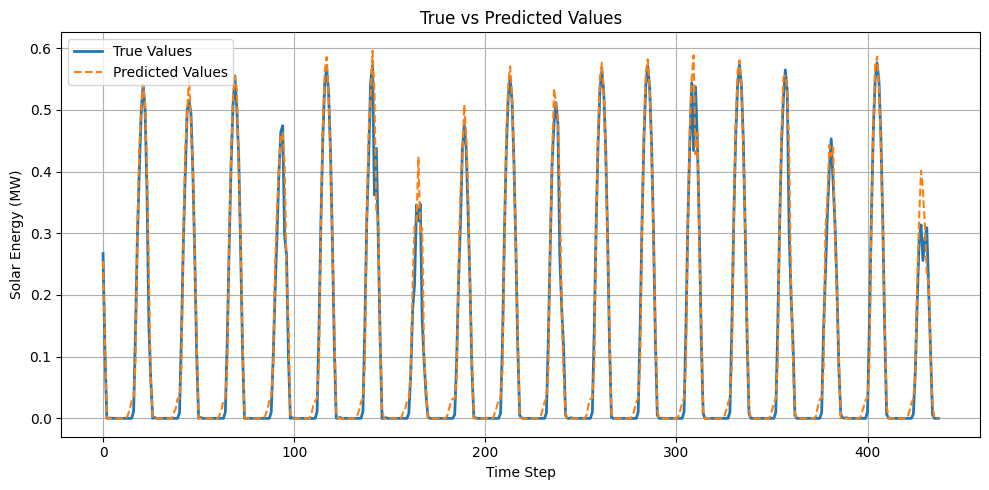

In [66]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

model = load_model('/kaggle/working/best_model_BiLSTM.h5', custom_objects={'mse': MeanSquaredError()})
y_pred = model.predict(X_test).flatten()
# y_pred[y_pred < 0] = 0


plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values', linewidth=2)
plt.plot(y_pred, label='Predicted Values', linestyle='--')
plt.title('True vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 1) Forcasting the 22 of future

In [67]:
future = pd.DataFrame()
future['SolarEnergy'] = y_pred
future

,SolarEnergy
0,0.254880
1,0.121250
2,0.000000
3,0.000000
4,0.000000
...,...
433,0.102196
434,0.022186
435,0.000000
436,0.000000


In [68]:
future[future.SolarEnergy < 0].shape[0]

0

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


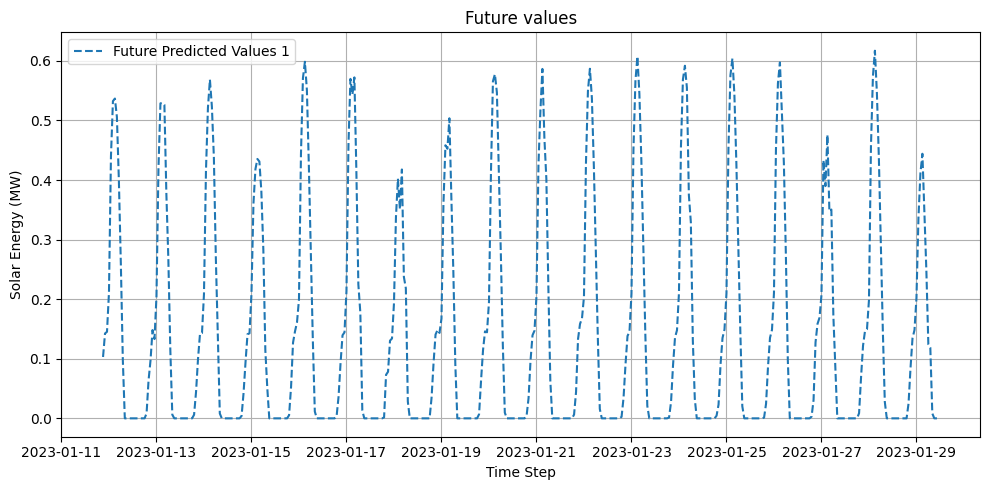

In [70]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError


model = load_model('/kaggle/working/best_model_BiLSTM.h5', custom_objects={'mse': MeanSquaredError()})
X, y = create_dataset(future.SolarEnergy, time_steps)
y_pred1 = model.predict(X).flatten()
# y_pred1[y_pred1 < 0] = 0

plt.figure(figsize=(10, 5))
plt.plot(pd.date_range(start='2023-01-11 21:00:00', periods = len(y_pred1), freq='h'),y_pred1, label='Future Predicted Values 1', linestyle='--')
plt.title('Future values')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) next 22 days

In [71]:
pd.date_range(start='2023-01-11 21:00:00', periods = len(y_pred1), freq='h')[-1]

Timestamp('2023-01-29 11:00:00')

In [72]:
future2 = pd.DataFrame()
future2['SolarEnergy'] = y_pred1
future2

,SolarEnergy
0,0.103002
1,0.142478
2,0.145253
3,0.211421
4,0.439647
...,...
418,0.118492
419,0.008320
420,0.000000
421,0.000000


In [73]:
future2[future2.SolarEnergy < 0].shape[0]

0

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


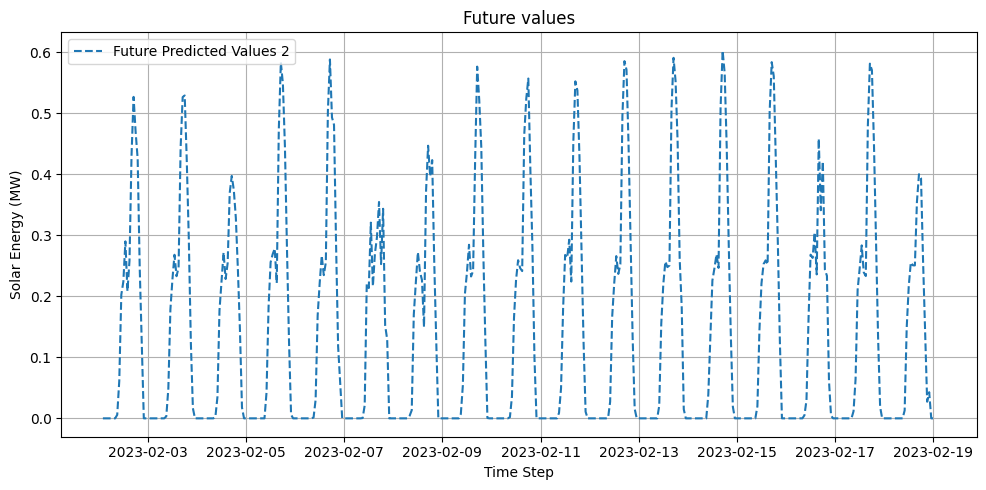

In [74]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError

X, y = create_dataset(future2.SolarEnergy, time_steps)
y_pred2 = model.predict(X).flatten()
# y_pred2[y_pred2 < 0] = 0

plt.figure(figsize=(10, 5))
plt.plot(pd.date_range(start='2023-02-02 02:00:00', periods = len(y_pred2), freq='h'),y_pred2, label='Future Predicted Values 2', linestyle='--')
plt.title('Future values')
plt.xlabel('Time Step')
plt.ylabel('Solar Energy (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saving model and directory

In [ ]:
!zip -r /kaggle/working/my_dir.zip /kaggle/working/my_dir

# Training the best model for more epochs

* BiLSTM Validation
* Loss: 0.001119
* Optimal Units: 288
* Optimal Learning Rate: 0.01
* Optimal Activation: relu


In [9]:
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Bidirectional(LSTM(units = 288, return_sequences=False, activation = 'relu',input_shape=(window_size, 1))))
model.add(Dense(1, activation = 'relu'))

model.compile(optimizer=Adam(learning_rate = 0.01), loss = 'mse', metrics = ['mae'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0523 - mae: 0.1387 - val_loss: 0.0074 - val_mae: 0.0596
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0060 - mae: 0.0404 - val_loss: 0.0059 - val_mae: 0.0518
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060 - mae: 0.0377 - val_loss: 0.0031 - val_mae: 0.0347
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - mae: 0.0372 - val_loss: 0.0042 - val_mae: 0.0435
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - mae: 0.0333 - val_loss: 0.0018 - val_mae: 0.0245
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - mae: 0.0370 - val_loss: 0.0019 - val_mae: 0.0271
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - mae: 0.0308 - val_loss: 0.0024 - val_mae: 0.0274
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - mae: 0.0322 - val_loss: 0.0027 - val_mae: 0.0338
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms

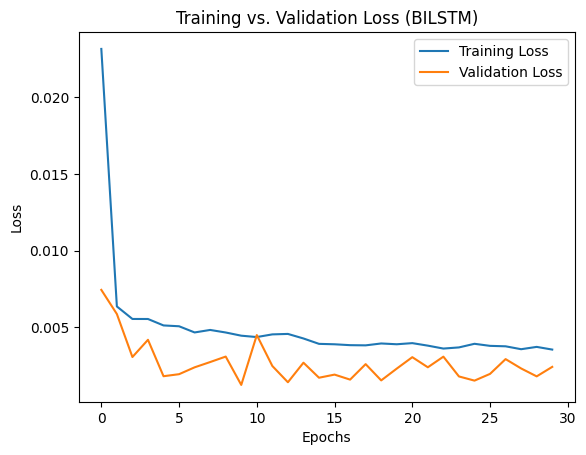

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (BILSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step 


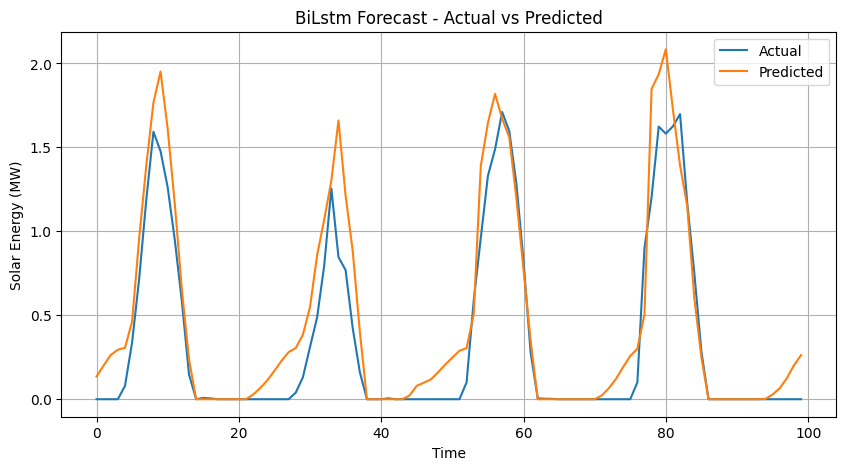

In [12]:
predictions = model.predict(X_test)


y_pred_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(y_pred_inverse[:100], label='Predicted')
plt.title("BiLstm Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Solar Energy (MW)")
plt.legend()
plt.grid(True)
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


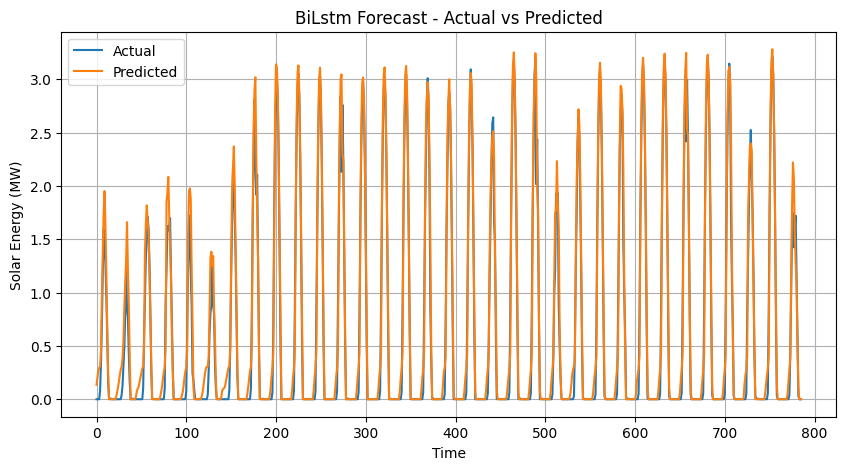

In [13]:
predictions = model.predict(X_test)


y_pred_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title("BiLstm Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Solar Energy (MW)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
from sklearn.metrics import r2_score

mse = np.mean((predictions - y_test) ** 2)
mae = np.mean(np.abs(predictions - y_test))
r2 = r2_score(y_test, predictions)

print(f"MSE (BILSTM): {mse:.4f}")
print(f"MAE (BILSTM): {mae:.4f}")
print(f"R² Score (BILSTM): {r2:.4f}")

MSE (BILSTM): 0.0010
MAE (BILSTM): 0.0176
R² Score (BILSTM): 0.9682


In [15]:
model.save('best_model_BILSTM_SolarEnergy.h5')